<a href="https://colab.research.google.com/github/BenjaminPhillips22/NLP-sentiment-analysis/blob/master/Sentiment_Analysis_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Self-Trained Embeddings, Sentence Average

This Notebook trains a neural network to determine if a movie review is positive or negative. Embeddings with 100 dimensions are created from the dataset itself. The input to the network is the average of the word embeddings of the review.

In [0]:
!pip install torch
!pip install torchtext

In [0]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext import vocab

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import random
import numpy as np

import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import Word



In [0]:

SEED = 1912

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, dev_data = train_data.split(random_state=random.seed(SEED))

imdb_data = {'train': train_data, 'test': test_data, 'dev': dev_data }

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 11.2MB/s]


In [0]:
nltk.download('stopwords')
nltk.download('wordnet')  # for lemmatize()
stop_words = stopwords.words('english')

In [0]:
lem = WordNetLemmatizer()
st = PorterStemmer()


def clean_text(sentence, stop_words, lem, st):
    """
    Take a sentence and clean it up. sentence is a list of strings    
    """
    
    sentence = [w.lower() for w in sentence]
    sentence = [re.sub(r'[^A-Za-z0-9]+', '', w) for w in sentence]
    sentence = [re.sub(r'https?:/\/\S+', '', w) for w in sentence]
    sentence = [w for w in sentence if w not in stop_words]
    sentence = [lem.lemmatize(w) for w in sentence]
    sentence = [st.stem(w) for w in sentence]
    sentence = list(filter(None, sentence))
    return sentence

Create our own word vectors

In [0]:
documents = [TaggedDocument(clean_text(e.text, stop_words, lem, st), [e.label]) for e in imdb_data['train'].examples]
model = Doc2Vec(documents, vector_size=100, window=20, min_count=10, workers=2, epochs=40)
word_vectors = model.wv

In [0]:
model.most_similar(positive=['film'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cinema', 0.466610312461853),
 ('indi', 0.424679696559906),
 ('franco', 0.4122822880744934),
 ('filmbr', 0.4018830955028534),
 ('oeuvr', 0.4004790484905243),
 ('worthwhil', 0.39420634508132935),
 ('filmmak', 0.38955575227737427),
 ('filmsbr', 0.38546454906463623),
 ('certainli', 0.38248181343078613),
 ('completist', 0.3814373016357422)]

In [0]:
model.most_similar(positive=['good'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('decent', 0.5909550189971924),
 ('alright', 0.5561862587928772),
 ('nice', 0.5455358028411865),
 ('darn', 0.4656652808189392),
 ('ok', 0.46072301268577576),
 ('okay', 0.458802193403244),
 ('weller', 0.45836615562438965),
 ('cool', 0.4398782253265381),
 ('great', 0.43936842679977417),
 ('nicebr', 0.43369394540786743)]

Now I want to make a function to take a training example and output the average of the word embeddings

In [0]:

def word_check(word, word_vectors):
    if word in word_vectors.vocab:
        return True, word_vectors[word]
    return False, None

In [0]:
def sentence_average(sentence, word_vectors):
    """ sentence is a list of words"""
    
    embeds = []
    for word in sentence:
        boo, woo = word_check(word, word_vectors)
        if boo:
            embeds.append(woo)
    
    # no suitable words
    if len(embeds)==0:
        return np.zeros(shape=word_vectors['good'].shape)
    return np.vstack(embeds).mean(axis=0)

In [0]:

keys = ['train', 'test', 'dev']
imdb_data_sentence_average = {}

for k in keys:
    print(k)
    data_average = []
    data_label = []
    for ex in imdb_data[k].examples:
        data_average.append(sentence_average(ex.text, word_vectors))
        if ex.label == 'pos':
            l = 1
        elif ex.label == 'neg':
            l = 0
        else:
            raise ValueError('unexpected value for label')

        data_label.append(l)
    
    imdb_data_sentence_average[k] = torch.utils.data.TensorDataset(
        torch.FloatTensor(data_average),
        torch.FloatTensor(data_label)
    )
    
        

train
test
dev


Time to make a model!!!

I experimented with different values for L2 Regularisation to prevent observed over-fitting

In [0]:
def my_auc(y, pred):
    import sklearn #.metrics.auc as auc
    y = y.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, pred)
    return sklearn.metrics.auc(fpr, tpr)


def get_dataset_auc(dataset, model):
    pred = model(dataset.tensors[0].cuda())
    labels = dataset.tensors[1]
    return my_auc(labels, pred)
    

In [0]:
BATCH_SIZE = 12
EPOCH = 21

net = torch.nn.Sequential(
        torch.nn.Linear(100, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
        torch.nn.Sigmoid()
    ).cuda()

loader = torch.utils.data.DataLoader(
    dataset=imdb_data_sentence_average['train'], 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-3)  # weight_decay is L2 regularization
criterion = torch.nn.BCEWithLogitsLoss().cuda()

train_set_auc = []
dev_set_auc = []


for epoch in range(EPOCH):
    for step, (batch_text, batch_label) in enumerate(loader): # for each training step
        
        batch_text = batch_text.cuda()
        batch_label = batch_label.cuda()

        optimizer.zero_grad()   # clear gradients for next train
  
        prediction = net(batch_text).squeeze(1)     # input x and predict based on x

        loss = criterion(prediction, batch_label)     # must be (1. nn output, 2. target)
        
        loss.backward()         # backpropagation, compute gradients
        
        optimizer.step()        # apply gradients
        
    # every epoche, get the training data auc and dev data auc
    tsa = get_dataset_auc(imdb_data_sentence_average['train'], net)
    dsa = get_dataset_auc(imdb_data_sentence_average['dev'], net)
    print('epoch: ', str(epoch), ' trainset auc: ', round(tsa, 2), ' dev set auc: ', round(dsa, 2))
    train_set_auc.append(tsa)
    dev_set_auc.append(dsa)
    
    # save and load models
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if epoch % 10 == 0:
        torch.save(net.state_dict(), 'self_trained_embeddings_sentence_average_' + str(epoch))

epoch:  0  trainset auc:  0.87  dev set auc:  0.88
epoch:  1  trainset auc:  0.88  dev set auc:  0.88
epoch:  2  trainset auc:  0.88  dev set auc:  0.88
epoch:  3  trainset auc:  0.88  dev set auc:  0.88
epoch:  4  trainset auc:  0.89  dev set auc:  0.89
epoch:  5  trainset auc:  0.89  dev set auc:  0.89
epoch:  6  trainset auc:  0.89  dev set auc:  0.89
epoch:  7  trainset auc:  0.89  dev set auc:  0.89
epoch:  8  trainset auc:  0.89  dev set auc:  0.89
epoch:  9  trainset auc:  0.89  dev set auc:  0.89
epoch:  10  trainset auc:  0.89  dev set auc:  0.89
epoch:  11  trainset auc:  0.9  dev set auc:  0.89
epoch:  12  trainset auc:  0.9  dev set auc:  0.89
epoch:  13  trainset auc:  0.9  dev set auc:  0.89
epoch:  14  trainset auc:  0.9  dev set auc:  0.89
epoch:  15  trainset auc:  0.9  dev set auc:  0.89
epoch:  16  trainset auc:  0.91  dev set auc:  0.89
epoch:  17  trainset auc:  0.91  dev set auc:  0.89
epoch:  18  trainset auc:  0.91  dev set auc:  0.89
epoch:  19  trainset auc:  

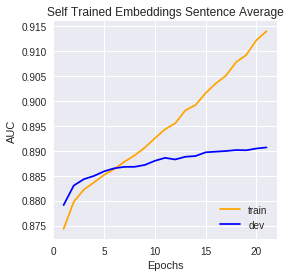

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

title = 'Self Trained Embeddings Sentence Average'

epochs = np.array(range(len(train_set_auc))) + 1
plt.figure(figsize=(4,4))
plt.plot(epochs, train_set_auc, color = "orange", label='train')
plt.plot(epochs, dev_set_auc, color = "blue", label='dev')
plt.legend(loc='lower right')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('AUC')
# plt.ylim((-0.05, 1.05))
plt.show()

fn = title + '.png'
plt.savefig(fn)
from google.colab import files
files.download(fn) 

In [0]:

!ls

 sample_data
 self_trained_embeddings_sentence_average_0
 self_trained_embeddings_sentence_average_10
 self_trained_embeddings_sentence_average_20
'Self Trained Embeddings Sentence Average.png'


How does it go on the test data?

In [0]:
net_1 = torch.nn.Sequential(
        torch.nn.Linear(100, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    ).cuda()
net_1.load_state_dict(torch.load('self_trained_embeddings_sentence_average_20'))
get_dataset_auc(imdb_data_sentence_average['test'], net_1)

0.878875248